# RFM

In [492]:
from toolkit import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
import datetime

# https://payzilch.atlassian.net/jira/software/c/projects/DT/boards/69?modal=detail&selectedIssue=DT-1574&assignee=6204058cff9289006eec2e88

In [185]:
# sql quaty from curren segmentation. I am not changing it and based on this calculation we will change segments
sql = '''
with cte_cust_usage as (
    select ledger_customer_id as customer_id
             ,'C' + REPLICATE('0',8-LEN(RTRIM(ledger_customer_id))) + CAST(ledger_customer_id AS VARCHAR) cid
             ,count(ledger_customer_ledger_id) as frequency
             ,sum(abs(ledger_amount)) as monetary
             ,date_diff('day',max(ledger_transaction_date::date),getdate()::date) as recency
             ,date_diff('month',min(ledger_transaction_date::date),getdate()::date) as months_with_zilch
             ,getdate()::date as run_date
        from warehouse_stage.stg_customer_ledger
        where ledger_transaction_type='PURCHASE'
        group by ledger_customer_id
    ),
     cte_blocks_active as (
         select customer_id
              ,block_type_id as most_recent_block_active_type_id
              ,blocked_date::date as most_recent_block_active_date
              ,bltp.code as most_recent_block_active_type_code
         from (select customer_id,block_type_id,blocked_date
                    ,row_number() over (partition by customer_id order by blocked_date desc) row_num_bl
                from customer.customer_block where is_active=1) cust_bl
         left join customer.customer_block_type bltp on cust_bl.block_type_id=bltp.id
         where row_num_bl=1
     )
select cid
     , cte_cust_usage.customer_id
     , c.customer_email_id
     , most_recent_block_active_type_id
     , most_recent_block_active_date
     , most_recent_block_active_type_code
     , frequency
     , monetary
     , recency
     , months_with_zilch
     , case when frequency <= percentile_cont(0.25) within group (order by frequency) over() then 1
            when frequency <= percentile_cont(0.50) within group (order by frequency) over() then 2
            when frequency <= percentile_cont(0.75) within group (order by frequency) over() then 3
            else 4 end as frequency_quartile
     , case when monetary <= percentile_cont(0.25) within group (order by monetary) over() then 1
            when monetary <= percentile_cont(0.50) within group (order by monetary) over() then 2
            when monetary <= percentile_cont(0.75) within group (order by monetary) over() then 3
            else 4 end as monetary_quartile
     , case when recency <= percentile_cont(0.25) within group (order by recency ) over() then 4
            when recency <= percentile_cont(0.50) within group (order by recency ) over() then 3
            when recency <= percentile_cont(0.75) within group (order by recency ) over() then 2
            else 1 end as recency_quartile
     , frequency_quartile+monetary_quartile+recency_quartile as rfm_score
     , case when rfm_score>=9 and frequency>=5 and recency<=60 and monetary>=50 then '1.Cannot lose them'
            when rfm_score>=8 and frequency>=2 and recency<=180 and monetary>=50 then '2.Champions'
            when rfm_score>=7 and frequency>=5 and monetary>=50 then '3.Loyal'
            when rfm_score>=6 and frequency>=2 and monetary>=30 then '4.Potential'
            when rfm_score>=5 and monetary>=10 then '5.Promising'
            when rfm_score>=4 then '6.Needs attention'
            else '7.Requires attention' end as rfm_level
     , run_date
from cte_cust_usage
left join cte_blocks_active on cte_cust_usage.customer_id=cte_blocks_active.customer_id
left join customer.customer c on cte_cust_usage.customer_id=c.customer_id

'''

In [187]:
df = db_to_df(sql)

/Users/anna.bartunova/Library/Caches/pypoetry/virtualenvs/toolkit-wlnJu52J-py3.9/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
# current segments describtion
for i in ['frequency','recency','monetary']:
    print(df.groupby('rfm_level').agg({i: [min,'median','mean',max, 'count']}))

frequency                                
                           min median       mean   max   count
rfm_level                                                     
1.Cannot lose them           5   21.0  38.639413  1074  200892
2.Champions                  2    5.0  13.268472   710   92818
3.Loyal                      5    8.0  13.329776   364   37665
4.Potential                  2    3.0   3.012008    38   93021
5.Promising                  1    1.0   1.590807   194  133541
6.Needs attention            1    1.0   1.180985    21   99290
7.Requires attention         1    1.0   1.000000     1   33344

recency                                 
                         min median        mean   max   count
rfm_level                                                    
1.Cannot lose them         0    7.0   12.409952    60  200892
2.Champions                0   71.0   71.578875   180   92818
3.Loyal                   17  225.0  260.883313  1009   37665
4.Potential                0  108.0  137.862311   966   93021
5.Promising                0  109.0  134.939247  1201  133541
6.Needs attention          0  127.0  183.174972  1116   99290
7.Requires attention     151  270.0  297.643984  1201   33344

monetary                                       
                          min  median         mean       max   count
rfm_level                                                           
1.Cannot lose them      52.92  915.37  1541.064376  26608.83  200892
2.Champions             50.00  287.84   612.831545  90158.53   92818
3.Loyal                 50.00  439.61   644.507867   9865.44   37665
4.Potential             30.00  134.88   152.820017   1798.99   93021
5.Promising             10.00  109.99   115.852601   1489.08  133541
6.Needs attention        0.01   50.00    57.669703    192.43   99290
7.Requires attention     0.01   49.91    44.845311     75.97   33344

In [14]:
# new segments based on merge that they have suggested, do results make seance - not too much
df['new_segment'] = 'best'
df.loc[df.rfm_level.isin(['3.Loyal','4.Potential', '5.Promising']), 'new_segment'] = 'median'
df.loc[df.rfm_level.isin(['6.Needs attention','7.Requires attention']), 'new_segment'] = 'min'

In [15]:
for i in ['frequency','recency','monetary']:
    print(df.groupby('new_segment').agg({i: [min,'median','mean',max, 'count']}))

frequency                                
                  min median       mean   max   count
new_segment                                          
best                2   15.0  30.621708  1074  293710
median              1    2.0   3.764506   364  264227
min                 1    1.0   1.135486    21  132634

recency                                 
                min median        mean   max   count
new_segment                                         
best              0   12.0   31.108468   180  293710
median            0  115.0  153.921371  1201  264227
min               0  164.0  211.952320  1201  132634

monetary                                        
                 min   median         mean       max   count
new_segment                                                 
best           50.00  653.255  1247.724977  90158.53  293710
median         10.00  137.850   204.225654   9865.44  264227
min             0.01   50.000    54.445669    192.43  132634

# Alive analises

In [52]:
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions 

In [41]:
# get historical data and train ModifiedBetaGeoFitter model (prediction number of transactions in some period in future)
# we will not use this model but we will use probability for custumer of being alive for next analises. the idea - connect recency and number of transacions with prob alive. 
sql = '''
 select 
            agg.customer_id,
            agg.loan_amount,
            agg.loan_date,
            agg.first_loan_date
     
        from warehouse.mrt_transaction as agg'''
df_all = db_to_df(sql)

In [47]:
model = summary_data_from_transaction_data(df_all[['customer_id','loan_amount','loan_date', 'first_loan_date']], 
                                               'customer_id', 'loan_date',monetary_value_col = 'loan_amount', freq = 'W')


In [58]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=.02)
bgf.fit(model['frequency'], model['recency'], model['T'])
model['alive'] = bgf.conditional_probability_alive( model['frequency'], model['recency'], model['T'])

In [76]:
model['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(4*5, model['frequency'], 
                                                                                               model['recency'], model['T'])
        

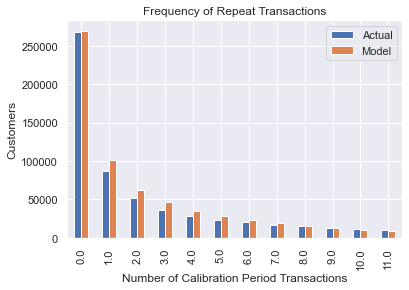

In [59]:
# check model quality
plot_period_transactions(bgf,max_frequency = 12)
plt.show()

In [90]:
# create bins for p. alive
model['alive_bins'] = pd.cut(model['alive'], 10)

In [106]:
df_all.sort_values('loan_date', inplace = True)
df_all['trasaction_number'] = df_all.groupby('customer_id').customer_id.cumcount()

In [140]:
df_all['next_tr_day'] = df_all.groupby('customer_id').loan_date.shift(-1)
df_all['days_between_tr'] = (df_all.next_tr_day - df_all.loan_date).dt.days


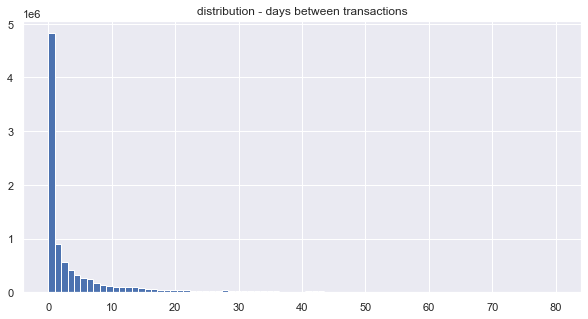

mean days =  6.503555579431465

median days =  1.0

In [150]:
df_all.days_between_tr.hist(bins = np.linspace(0,80,80), figsize = [10,5])
plt.title('distribution - days between transactions for ALL customers')
plt.show()
print('mean days = ',df_all.days_between_tr.mean())
print('median days = ',df_all.days_between_tr.median())


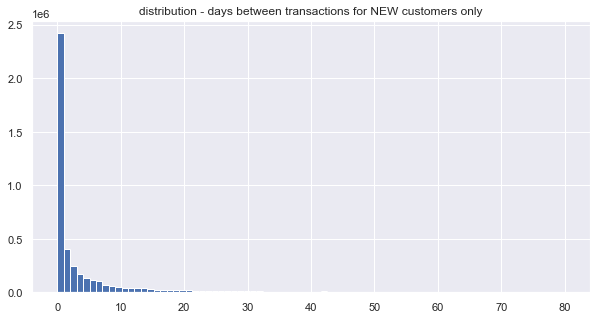

mean days =  5.178123762513008

median days =  1.0

In [165]:
new_c = df_all.loc[df_all.first_loan_date>datetime.date(2021, 8, 1)]
new_c.days_between_tr.hist(bins = np.linspace(0,80,80), figsize = [10,5])
plt.title('distribution - days between transactions for NEW customers only')
plt.show()
print('mean days = ',new_c.days_between_tr.mean())
print('median days = ',new_c.days_between_tr.median())


In [176]:
stat_transaction_time = new_c.groupby('customer_id').agg({'trasaction_number':max, 'days_between_tr': ['mean']})
stat_transaction_time.columns = ['trasaction_number', 'mean']

Text(0.5, 1.0, 'average number ov days between transactions vs number of transactions')

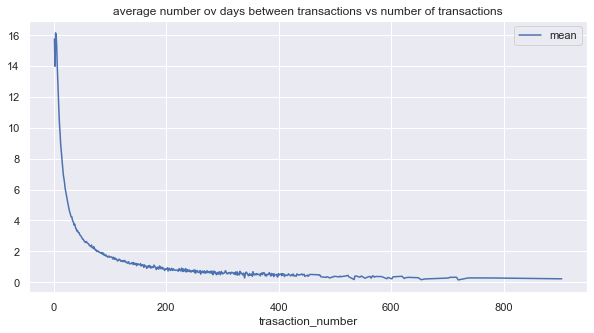

In [178]:
stat_transaction_time.groupby('trasaction_number').mean().plot(figsize = [10,5])
plt.title('average number ov days between transactions vs number of transactions')

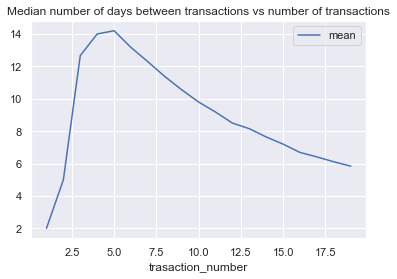

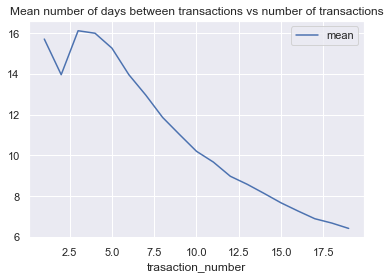

In [491]:
# connection between number of transactions and average number of days between transactions
stat_transaction_time.loc[stat_transaction_time.trasaction_number<20].groupby('trasaction_number').median().plot()
plt.title('Median number of days between transactions vs number of transactions')
plt.show()

stat_transaction_time.loc[stat_transaction_time.trasaction_number<20].groupby('trasaction_number').mean().plot()
plt.title('Mean number of days between transactions vs number of transactions')
plt.show()
# suggesion - take 16 days as resonable number of days beein not active with high probability of making next transaction.

<AxesSubplot:xlabel='frequency'>

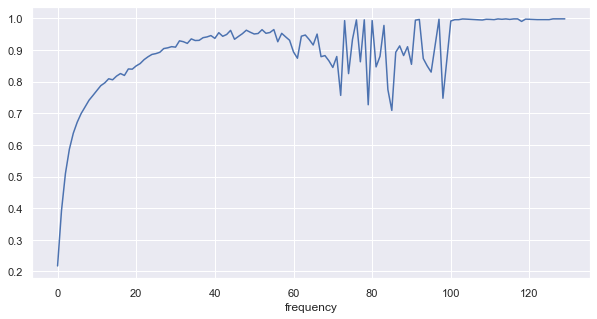

In [345]:
model.groupby('frequency').alive.mean().plot(figsize = [10,5])

>80% of customers with frequency> 30 has prob alive close to 100%

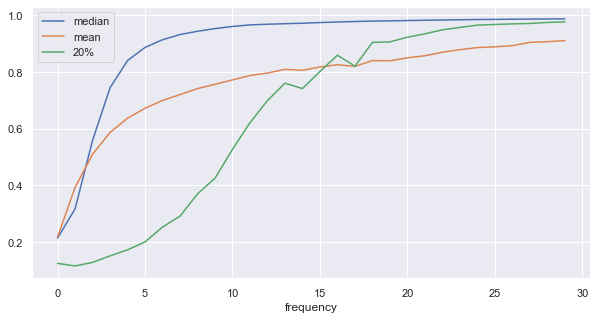

In [439]:
model.loc[model.frequency<30].groupby('frequency').alive.median().plot(figsize = [10,5] ,label = 'median')
model.loc[model.frequency<30].groupby('frequency').alive.mean().plot(figsize = [10,5], label = 'mean')
model.loc[model.frequency<30].groupby('frequency').alive.quantile(.2).plot(figsize = [10,5], label = '20%')
plt.legend()
print('>80% of customers with frequency> 30 has prob alive close to 100%')

Text(0.5, 1.0, ' monetary_value histogram')

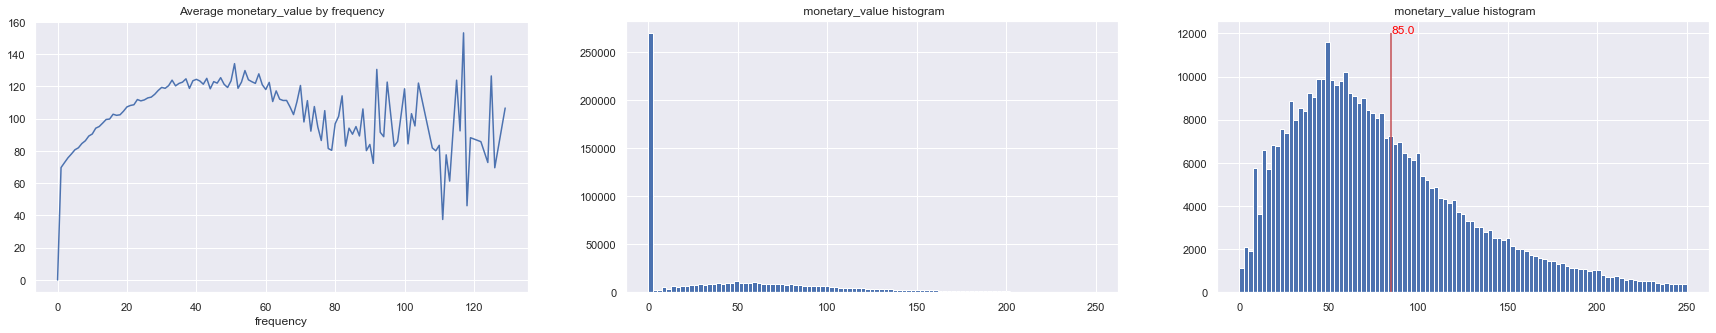

In [448]:
plt.subplot(131)
model.groupby('frequency').monetary_value.mean().plot(figsize = [30,5])
plt.title('Average monetary_value by frequency')

plt.subplot(132)
model.monetary_value.hist(bins = np.linspace(0,250,100))
plt.title(' monetary_value histogram')

plt.subplot(133)
model.loc[model.monetary_value>0].monetary_value.hist(bins = np.linspace(0,250,100))
plt.vlines(model.loc[model.monetary_value>0].monetary_value.mean(),0,12000, color = 'r')
mean_monetary_value = model.loc[model.monetary_value>0].monetary_value.mean()
plt.text(mean_monetary_value,12000,str(np.round(mean_monetary_value)), color = 'red')

plt.title(' monetary_value histogram')

In [484]:
# cinditions for spliting customers for RFM model
df['recency_flag'] = (df.recency<16)*1
df['frequency_flag'] = (df.frequency>25)*1
df['monetary_flag'] = (df.monetary>85)*1

In [485]:
# naming segments
df['combine_score'] = df[['recency_flag','frequency_flag', 'monetary_flag']].apply(lambda x: str(x[0]) +str(x[1])+str(x[2]), axis =1)
df['combine_score'] = df.combine_score.replace({'000':'3. gone', 
                                                '011' : '70. attention!!!',
                                                '001':'30. gone',
                                                '010':'7. attention!!!',
                                                '100': '20. loyal',
                                                '101':'10. winners',
                                                '110':'2. loyal',
                                                '111':'1. winners',
                                                
                                               })

In [486]:
# segmets describtions based on recency, frequency, monetary
np.round(df.groupby('combine_score').agg({'recency': [min,  'mean','median', max],
                                'frequency': [min, 'mean', max],
                                'monetary': [min,'mean', max]})).T

combine_score 
 1. winners 
 10. winners 
 2. loyal 
 20. loyal 
 3. gone 
 30. gone 
 7. attention!!! 
 70. attention!!! 
 
 
 
 
 recency 
 min 
 0.0 
 0.0 
 1.0 
 0.0 
 16.0 
 16.0 
 18.0 
 16.0 
 
 
 mean 
 4.0 
 6.0 
 4.0 
 7.0 
 154.0 
 150.0 
 67.0 
 100.0 
 
 
 median 
 3.0 
 6.0 
 2.0 
 7.0 
 111.0 
 114.0 
 77.0 
 73.0 
 
 
 max 
 15.0 
 15.0 
 14.0 
 15.0 
 1202.0 
 1202.0 
 117.0 
 945.0 
 
 
 frequency 
 min 
 26.0 
 1.0 
 26.0 
 1.0 
 1.0 
 1.0 
 26.0 
 26.0 
 
 
 mean 
 75.0 
 11.0 
 84.0 
 3.0 
 2.0 
 5.0 
 54.0 
 55.0 
 
 
 max 
 1089.0 
 25.0 
 323.0 
 24.0 
 23.0 
 25.0 
 194.0 
 710.0 
 
 
 monetary 
 min 
 93.0 
 85.0 
 12.0 
 0.0 
 0.0 
 85.0 
 24.0 
 86.0 
 
 
 mean 
 2804.0 
 562.0 
 53.0 
 49.0 
 44.0 
 317.0 
 47.0 
 2169.0 
 
 
 max 
 26689.0 
 10095.0 
 79.0 
 85.0 
 85.0 
 6694.0 
 82.0 
 90159.0

<AxesSubplot:ylabel='combine_score'>

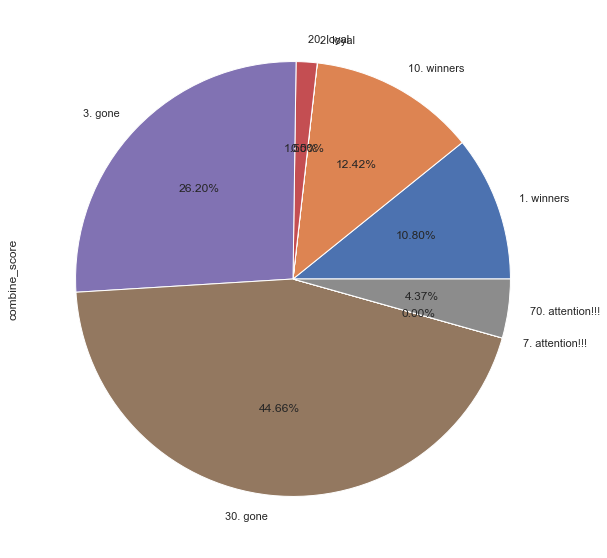

In [487]:
# proportion of segments in the book
(df.groupby('combine_score').combine_score.count()/df.shape[0]).plot.pie(figsize = [10,10] ,autopct='%.2f%%')

<AxesSubplot:ylabel='combine_score'>

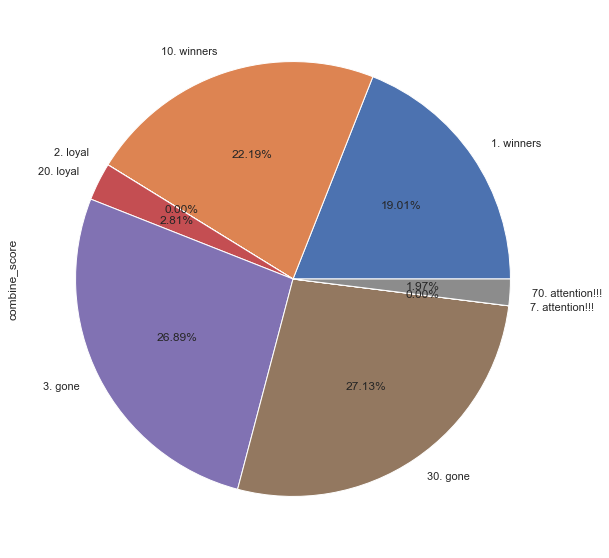

In [494]:
# proportion of segments in the book just for not bloked customers
(df.loc[df.most_recent_block_active_type_id.isna()].groupby('combine_score').combine_score.count()/df.shape[0]).plot.pie(figsize = [10,10] ,autopct='%.2f%%')

In [495]:
# segmets describtions based on recency, frequency, monetaryjust for not bloked customers
np.round(df.loc[df.most_recent_block_active_type_id.isna()].groupby('combine_score').agg({'recency': [min,  'mean','median', max],
                                'frequency': [min, 'mean', max],
                                'monetary': [min,'mean', max]})).T

combine_score 
 1. winners 
 10. winners 
 2. loyal 
 20. loyal 
 3. gone 
 30. gone 
 7. attention!!! 
 70. attention!!! 
 
 
 
 
 recency 
 min 
 0.0 
 0.0 
 1.0 
 0.0 
 16.0 
 16.0 
 20.0 
 16.0 
 
 
 mean 
 4.0 
 6.0 
 2.0 
 7.0 
 119.0 
 97.0 
 77.0 
 44.0 
 
 
 median 
 3.0 
 5.0 
 1.0 
 6.0 
 107.0 
 59.0 
 94.0 
 25.0 
 
 
 max 
 15.0 
 15.0 
 5.0 
 15.0 
 1202.0 
 1010.0 
 117.0 
 888.0 
 
 
 frequency 
 min 
 26.0 
 1.0 
 28.0 
 1.0 
 1.0 
 1.0 
 26.0 
 26.0 
 
 
 mean 
 75.0 
 11.0 
 92.0 
 3.0 
 2.0 
 6.0 
 83.0 
 49.0 
 
 
 max 
 1089.0 
 25.0 
 323.0 
 24.0 
 21.0 
 25.0 
 194.0 
 438.0 
 
 
 monetary 
 min 
 93.0 
 85.0 
 12.0 
 0.0 
 0.0 
 85.0 
 25.0 
 86.0 
 
 
 mean 
 2818.0 
 563.0 
 49.0 
 49.0 
 34.0 
 355.0 
 37.0 
 2093.0 
 
 
 max 
 26689.0 
 10095.0 
 79.0 
 85.0 
 85.0 
 6694.0 
 59.0 
 22257.0

<AxesSubplot:>

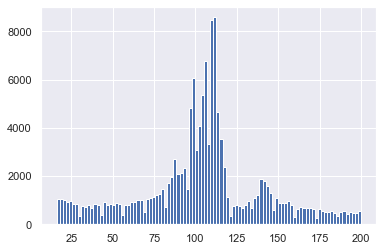

In [499]:
# recency distribution 
df.loc[df.combine_score == '3. gone'].recency.hist(bins = np.linspace(16,200,100))

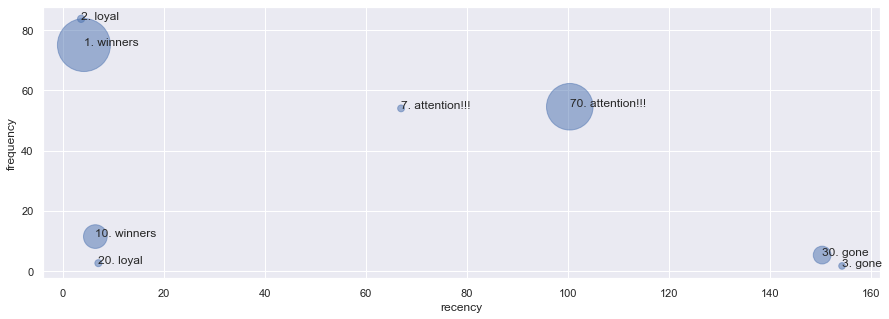

In [488]:
print_chart = df.groupby('combine_score')[['recency', 'frequency', 'monetary']].mean()
plt.figure(figsize = [15,5])
plt.scatter(print_chart.recency, print_chart.frequency , s = print_chart.monetary, alpha = 0.5)
plt.xlabel('recency')
plt.ylabel('frequency')
for i in print_chart.index:
    plt.text(print_chart.loc[i, 'recency'],print_chart.loc[i, 'frequency'], str(i))

# Final sql quary 

In [ ]:
sql = '''
with cte_cust_usage as (
    select ledger_customer_id as customer_id
             ,'C' + REPLICATE('0',8-LEN(RTRIM(ledger_customer_id))) + CAST(ledger_customer_id AS VARCHAR) cid
             ,count(ledger_customer_ledger_id) as frequency
             ,sum(abs(ledger_amount)) as monetary
             ,date_diff('day',max(ledger_transaction_date::date),getdate()::date) as recency
             ,date_diff('month',min(ledger_transaction_date::date),getdate()::date) as months_with_zilch
             ,getdate()::date as run_date
        from warehouse_stage.stg_customer_ledger
        where ledger_transaction_type='PURCHASE'
        group by ledger_customer_id
    ),
     cte_blocks_active as (
         select customer_id
              ,block_type_id as most_recent_block_active_type_id
              ,blocked_date::date as most_recent_block_active_date
              ,bltp.code as most_recent_block_active_type_code
         from (select customer_id,block_type_id,blocked_date
                    ,row_number() over (partition by customer_id order by blocked_date desc) row_num_bl
                from customer.customer_block where is_active=1) cust_bl
         left join customer.customer_block_type bltp on cust_bl.block_type_id=bltp.id
         where row_num_bl=1
     )
select cid
     , cte_cust_usage.customer_id
     , c.customer_email_id
     , most_recent_block_active_type_id
     , most_recent_block_active_date
     , most_recent_block_active_type_code
     , frequency
     , monetary
     , recency
     , months_with_zilch

     , case when recency < 16  and monetary > 85 then 'Winners'
            when recency < 16 and monetary <= 85 then 'Loyal'
            when recency >=16 and frequency>25 then 'Attention'
            else 'Gone' end as rfm_level
            
     , case when months_with_zilch = 0 then 'New customer'
            else 'not new'end  as new_customer_flag
     , run_date
from cte_cust_usage
left join cte_blocks_active on cte_cust_usage.customer_id=cte_blocks_active.customer_id
left join customer.customer c on cte_cust_usage.customer_id=c.customer_id

'''